In [ ]:
# Deteksi Anomali Suhu — Notebook (Rapi)
Notebook ini melakukan deteksi anomali pada data suhu IoT menggunakan model CNN-LSTM. Tujuan: menyiapkan data, melatih model, melakukan tuning hyperparameter, dan mengevaluasi hasil. Jalankan sel secara berurutan dari atas ke bawah.

# Load Data Dan EDA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## Imports & Setup
Memuat pustaka yang diperlukan: manipulasi data (pandas, numpy), visualisasi (matplotlib, seaborn), preprocessing (MinMaxScaler), serta library untuk model dan evaluasi.

In [ ]:
df = pd.read_csv("IOT-temp.csv")

In [ ]:
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [ ]:
## Data Loading & Inspeksi
Membaca file CSV dan memeriksa baris awal untuk memahami struktur kolom, tipe data, dan adanya nilai hilang.

In [ ]:
df = df.rename(columns={
    'noted_date': 'timestamp',
    'temp': 'temperature',
    'out/in': 'location'
})

df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

df['location'] = df['location'].map({'In': 0, 'Out': 1})

df = df.sort_values('timestamp').reset_index(drop=True)


In [ ]:
## Preprocessing
Membersihkan dan menormalkan data: mengganti nama kolom, konversi timestamp, mapping label `location`, dan pengurutan berdasarkan waktu.

In [ ]:
df[['timestamp']].head()
df[['timestamp']].tail()

,timestamp
97601,2018-12-08 09:29:00
97602,2018-12-08 09:29:00
97603,2018-12-08 09:29:00
97604,2018-12-08 09:30:00
97605,2018-12-08 09:30:00


In [ ]:
from scipy.stats import zscore

df['z_score'] = zscore(df['temperature'])

# Threshold anomali
THRESHOLD = 2

df['outlier'] = (abs(df['z_score']) > THRESHOLD).astype(int)
df['outlier'].value_counts()

,count
outlier,
0,95107
1,2499


In [ ]:
scaler = MinMaxScaler()

df[['temp_norm', 'location_norm']] = scaler.fit_transform(
    df[['temperature', 'location']]
)

In [ ]:
def sliding_window(features, labels, window_size=30):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(labels[i+window_size-1])
    return np.array(X), np.array(y)

FEATURES = df[['temp_norm', 'location_norm']].values
LABELS = df['outlier'].values

WINDOW_SIZE = 30
X, y = sliding_window(FEATURES, LABELS, WINDOW_SIZE)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (97576, 30, 2)
y shape: (97576,)


In [ ]:
## Feature Engineering & Windowing
Menormalkan fitur dan menerapkan sliding window untuk menangkap konteks temporal (window size = 30). Label ditentukan berdasarkan titik akhir jendela.

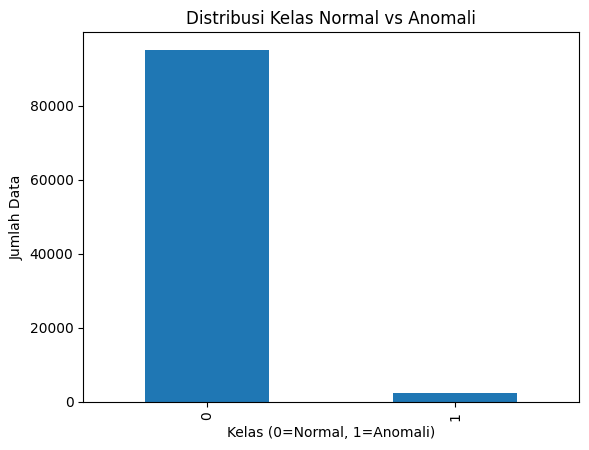

In [ ]:
plt.figure()
df['outlier'].value_counts().plot(kind='bar')
plt.title("Distribusi Kelas Normal vs Anomali")
plt.xlabel("Kelas (0=Normal, 1=Anomali)")
plt.ylabel("Jumlah Data")
plt.show()

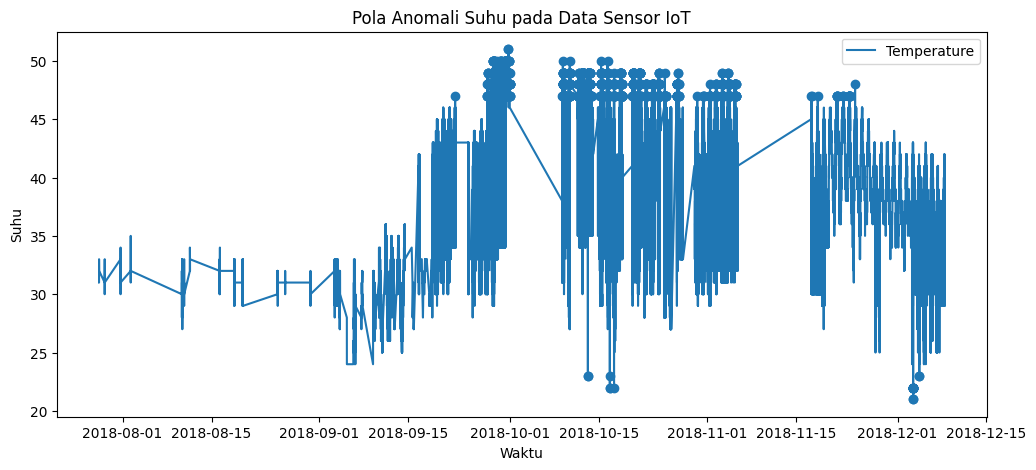

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['timestamp'], df['temperature'], label='Temperature')

anomaly = df[df['outlier'] == 1]
plt.scatter(anomaly['timestamp'], anomaly['temperature'])

plt.title("Pola Anomali Suhu pada Data Sensor IoT")
plt.xlabel("Waktu")
plt.ylabel("Suhu")
plt.legend()
plt.show()

In [ ]:
## Exploratory Data Analysis
Visualisasi distribusi kelas dan pola anomali untuk memahami sebaran dan bagaimana anomali muncul di seri waktu.

In [ ]:
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print(X_train.shape, X_val.shape, X_test.shape)

(68303, 30, 2) (14636, 30, 2) (14637, 30, 2)


In [ ]:
## Train/Val/Test Split
Membagi data secara berurutan (tanpa shuffle) untuk menjaga kronologi; proporsi: 70% train, 15% val, 15% test.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

print(class_weight)

{0: np.float64(0.5131319960934565), 1: np.float64(19.537471395881006)}


In [ ]:
## Class Weight
Menghitung bobot kelas seimbang menggunakan `compute_class_weight` untuk mengatasi ketidakseimbangan label saat pelatihan.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
## Model & Training Setup
Mengimpor layer dan utilitas Keras yang dibutuhkan untuk membangun arsitektur CNN-LSTM, optimizer, dan callbacks.

In [ ]:
def build_cnn_lstm(
    kernel_size=3,
    filters=64,
    lstm_units=64,
    dropout=0.3,
    cnn_layers=1,
    lr=1e-4
):
    model = Sequential()

    for i in range(cnn_layers):
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            input_shape=(X.shape[1], X.shape[2]) if i == 0 else None
        ))
        model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
## Arsitektur Model
Fungsi `build_cnn_lstm` membuat model CNN-LSTM yang bisa dikustomisasi: jumlah filter, ukuran kernel, unit LSTM, dropout, dan learning rate.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
model_base = build_cnn_lstm()

history_base = model_base.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6267 - loss: 0.3911
Epoch 1: val_loss improved from inf to 0.49028, saving model to best_cnn_lstm_model.h5


1068/1068 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6269 - loss: 0.3910 - val_accuracy: 0.8042 - val_loss: 0.4903
Epoch 2/50
1060/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9642 - loss: 0.1064
Epoch 2: val_loss improved from 0.49028 to 0.33780, saving model to best_cnn_lstm_model.h5


1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9642 - loss: 0.1064 - val_accuracy: 0.8491 - val_loss: 0.3378
Epoch 3/50
1060/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9649 - loss: 0.1055
Epoch 3: val_loss did not improve from 0.33780
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9649 - loss: 0.1055 - val_accuracy: 0.8037 - val_loss: 0.4652
Epoch 4/50
1064/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9630 - loss: 0.0962
Epoch 4: val_loss did not improve from 0.33780
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9630 - loss: 0.0962 - val_accuracy: 0.8433 - val_loss: 0.3745
Epoch 5/50
1067/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9661 - loss: 0.0895
Epoch 5: val_loss improved from 0.33780 to 0.26167, saving model to best_cnn_lstm_model.h5


1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9661 - loss: 0.0895 - val_accuracy: 0.8731 - val_loss: 0.2617
Epoch 6/50
1066/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9682 - loss: 0.0828
Epoch 6: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9682 - loss: 0.0828 - val_accuracy: 0.8040 - val_loss: 0.4845
Epoch 7/50
1065/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9668 - loss: 0.0836
Epoch 7: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9668 - loss: 0.0836 - val_accuracy: 0.8474 - val_loss: 0.3408
Epoch 8/50
1062/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9681 - loss: 0.0764
Epoch 8: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9681 - loss: 0.0763 - val_accuracy: 0.8239 - val_loss: 0.4240
Epoch 9/50
1062/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9692 - loss: 0.0703
Epoch 9: val_loss did not impro

### Variasi 1 — Kernel Lebih Besar
Menguji efek penggunaan kernel size yang lebih besar pada lapisan Conv1D untuk melihat perubahan kemampuan ekstraksi fitur.

In [ ]:
model_v1 = build_cnn_lstm(kernel_size=5)

history_v1 = model_v1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1066/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5745 - loss: 0.4376
Epoch 1: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5751 - loss: 0.4371 - val_accuracy: 0.8480 - val_loss: 0.3211
Epoch 2/50
1065/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9581 - loss: 0.1203
Epoch 2: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9581 - loss: 0.1203 - val_accuracy: 0.7414 - val_loss: 0.7057
Epoch 3/50
1059/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9638 - loss: 0.1096
Epoch 3: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9639 - loss: 0.1095 - val_accuracy: 0.8134 - val_loss: 0.3948
Epoch 4/50
1065/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9652 - loss: 0.0942
Epoch 4: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9652 - loss: 0.0942 - val_accuracy: 0.8295 - v

### Variasi 2 — CNN Bertingkat
Menambahkan lapisan Conv1D tambahan untuk melihat dampak kedalaman CNN pada performa deteksi anomali.

In [ ]:
model_v2 = build_cnn_lstm(cnn_layers=2)

history_v2 = model_v2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7036 - loss: 0.3698
Epoch 1: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7038 - loss: 0.3696 - val_accuracy: 0.8416 - val_loss: 0.3409
Epoch 2/50
1065/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9650 - loss: 0.0985
Epoch 2: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9650 - loss: 0.0985 - val_accuracy: 0.7790 - val_loss: 0.5480
Epoch 3/50
1062/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9664 - loss: 0.0840
Epoch 3: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9664 - loss: 0.0841 - val_accuracy: 0.8369 - val_loss: 0.3594
Epoch 4/50
1067/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9669 - loss: 0.0879
Epoch 4: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9669 - loss: 0.0879 - val_accuracy: 0.7939 -

### Variasi 3 — LSTM Lebih Dalam
Meningkatkan jumlah unit LSTM untuk menangkap dependensi temporal yang lebih kompleks.

In [ ]:
model_v3 = build_cnn_lstm(lstm_units=128)

history_v3 = model_v3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1066/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8001 - loss: 0.3573
Epoch 1: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8004 - loss: 0.3568 - val_accuracy: 0.7626 - val_loss: 0.6433
Epoch 2/50
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9626 - loss: 0.1035
Epoch 2: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9626 - loss: 0.1035 - val_accuracy: 0.8021 - val_loss: 0.4423
Epoch 3/50
1066/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9634 - loss: 0.0943
Epoch 3: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9634 - loss: 0.0943 - val_accuracy: 0.8371 - val_loss: 0.3423
Epoch 4/50
1066/1068 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9652 - loss: 0.0882
Epoch 4: val_loss did not improve from 0.26167
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9652 - loss: 0.0882 - val_accuracy: 0.8467 - v

## Hyperparameter Tuning
Menggunakan Keras-Tuner (RandomSearch) untuk mengeksplorasi kombinasi hyperparameter dan memilih model terbaik berdasarkan `val_loss`.

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def build_cnn_lstm_tuner(hp):
    model = Sequential()

    filters = hp.Choice('filters', [32, 64])
    kernel_size = hp.Choice('kernel_size', [3, 5])
    lstm_units = hp.Choice('lstm_units', [32, 64, 128])
    dropout = hp.Float('dropout', 0.2, 0.5, step=0.1)
    lr = hp.Choice('lr', [1e-3, 1e-4])

    model.add(Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=(X.shape[1], X.shape[2])
    ))
    model.add(MaxPooling1D(2))

    # Force non-CuDNN LSTM by setting unroll=True
    model.add(LSTM(lstm_units, recurrent_activation='sigmoid', use_bias=True, unroll=True))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_cnn_lstm_tuner,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning',
    project_name='cnn_lstm_iot_v2' # Changed project name for a fresh search
)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 01m 06s]
val_loss: 0.26027658581733704

Best val_loss So Far: 0.04428005591034889
Total elapsed time: 00h 18m 32s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,897 (50.38 KB)

 Trainable params: 12,897 (50.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Evaluasi Model
Mengukur metrik kunci (Accuracy, Precision, Recall, F1, ROC-AUC) pada data test untuk menilai performa model.

##EVALUASI

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)


In [ ]:
y_pred_prob = model_base.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_prob)

print("CNN-LSTM Performance")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("ROC-AUC  :", roc)

CNN-LSTM Performance
Accuracy : 0.9743116758898681
Precision: 0.18840579710144928
Recall   : 0.6610169491525424
F1-score : 0.2932330827067669
ROC-AUC  : 0.9691187818183303


## SVM Baseline
Menguji SVM sebagai model pembanding klasik (reshape input agar cocok dengan estimator non-temporal seperti SVM).

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True, class_weight='balanced')
svm.fit(X_train_flat, y_train)

y_pred_svm = svm.predict(X_test_flat)
y_prob_svm = svm.predict_proba(X_test_flat)[:, 1]

In [ ]:
print("SVM Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall   :", recall_score(y_test, y_pred_svm))
print("F1-score :", f1_score(y_test, y_pred_svm))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_svm))

SVM Performance
Accuracy : 0.9868142378902781
Precision: 0.3552123552123552
Recall   : 0.7796610169491526
F1-score : 0.4880636604774536
ROC-AUC  : 0.973834111001248


## Perbandingan Model
Menyusun tabel ringkasan metrik untuk membandingkan CNN-LSTM (dasar), CNN-LSTM (tuned), dan SVM.

In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["CNN-LSTM", "SVM"],
    "Accuracy": [acc, accuracy_score(y_test, y_pred_svm)],
    "Precision": [prec, precision_score(y_test, y_pred_svm)],
    "Recall": [rec, recall_score(y_test, y_pred_svm)],
    "F1-score": [f1, f1_score(y_test, y_pred_svm)],
    "ROC-AUC": [roc, roc_auc_score(y_test, y_prob_svm)]
})

results

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,CNN-LSTM,0.974312,0.188406,0.661017,0.293233,0.969119
1,SVM,0.986814,0.355212,0.779661,0.488064,0.973834


## Ekspor Model
Menyimpan model terbaik ke file `.h5` dan mengkonversi model hasil tuning ke format TFLite untuk deployment ringan.

In [ ]:
# Export placeholder
# Sel ini digunakan sebagai titik untuk menempatkan kode ekspor tambahan bila diperlukan.

In [ ]:
best_model.save("cnn_lstm_iot.h5")

In [ ]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_USE_CUDNN"] = "0"

In [ ]:
import tensorflow as tf


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


rebuilt_model = build_cnn_lstm_tuner(best_hps)


rebuilt_model.set_weights(best_model.get_weights())

converter = tf.lite.TFLiteConverter.from_keras_model(rebuilt_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("cnn_lstm_iot.tflite", "wb") as f:
    f.write(tflite_model)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved artifact at '/tmp/tmpjzlyef7t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139427249546320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139426809762768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139426809764688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139426809758736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139426809767184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139426809766608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139426809764112: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
## Visualisasi Hasil
Memplot ROC, Precision-Recall, confusion matrix, dan visualisasi segment data untuk melihat prediksi aktual vs prediksi model pada interval waktu nyata.

## Visualisasi Distribusi Label Setelah Windowing




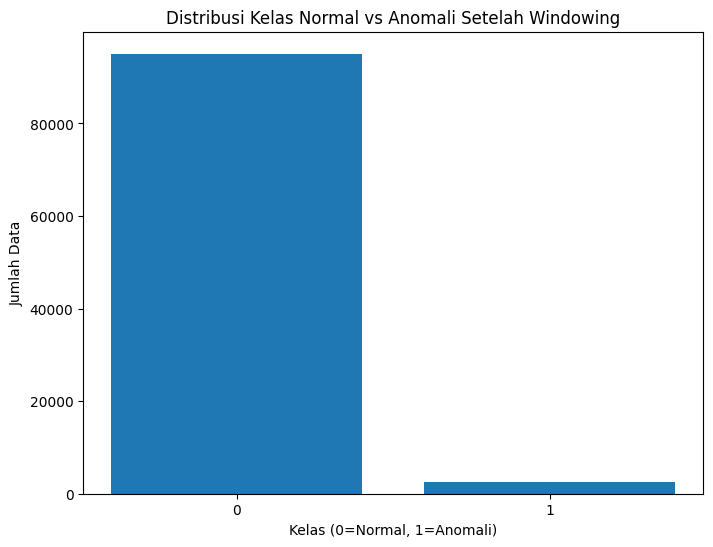

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


class_counts = np.unique(y, return_counts=True)
class_labels = class_counts[0]
class_values = class_counts[1]


plt.figure(figsize=(8, 6))
plt.bar(class_labels.astype(str), class_values, tick_label=class_labels.astype(str))


plt.xlabel('Kelas (0=Normal, 1=Anomali)')
plt.ylabel('Jumlah Data')


plt.title('Distribusi Kelas Normal vs Anomali Setelah Windowing')


plt.show()

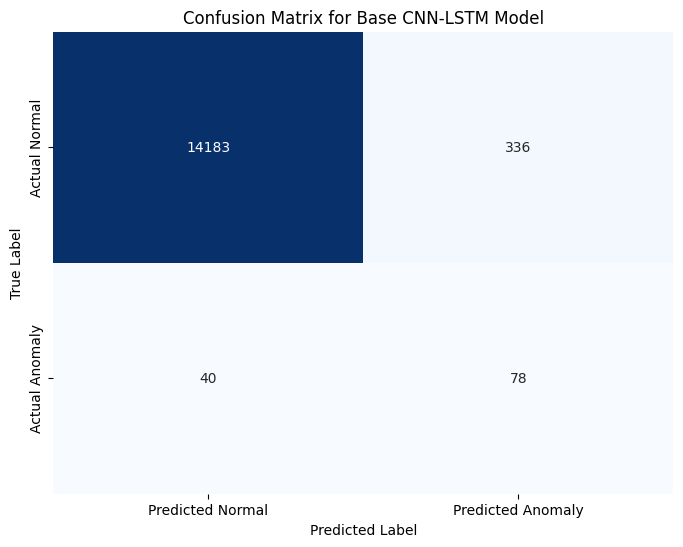

In [ ]:
import seaborn as sns


cm_base = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Base CNN-LSTM Model')
plt.show()

458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Tuned CNN-LSTM Performance
Accuracy : 0.9950809592129535
Precision: 0.6885245901639344
Recall   : 0.711864406779661
F1-score : 0.7
ROC-AUC  : 0.9574018148049137


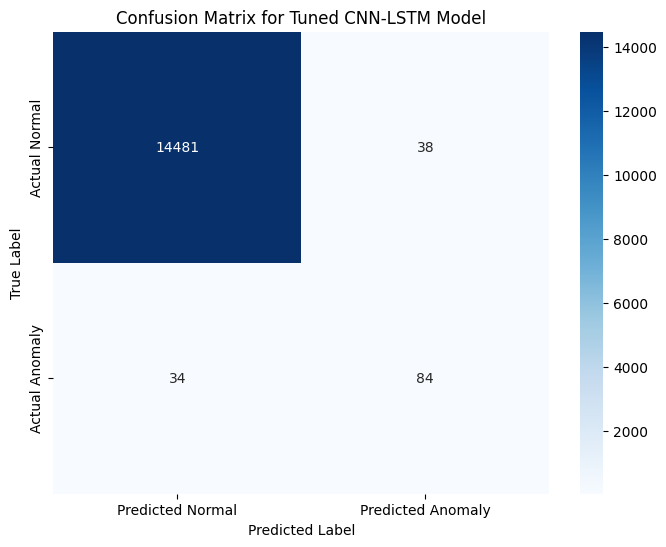

In [ ]:
y_pred_prob_tuned = best_model.predict(X_test)
y_pred_tuned = (y_pred_prob_tuned > 0.5).astype(int)


acc_tuned = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned)
rec_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)

print("Tuned CNN-LSTM Performance")
print("Accuracy :", acc_tuned)
print("Precision:", prec_tuned)
print("Recall   :", rec_tuned)
print("F1-score :", f1_tuned)
print("ROC-AUC  :", roc_tuned)


cm_tuned = confusion_matrix(y_test, y_pred_tuned)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned CNN-LSTM Model')
plt.show()

In [ ]:
tuned_results = pd.DataFrame({
    "Model": ["CNN-LSTM (Tuned)"],
    "Accuracy": [acc_tuned],
    "Precision": [prec_tuned],
    "Recall": [rec_tuned],
    "F1-score": [f1_tuned],
    "ROC-AUC": [roc_tuned]
})

results = pd.concat([results, tuned_results], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,CNN-LSTM,0.974312,0.188406,0.661017,0.293233,0.969119
1,SVM,0.986814,0.355212,0.779661,0.488064,0.973834
2,CNN-LSTM (Tuned),0.995081,0.688525,0.711864,0.700000,0.957402


## Visualisasi Kurva ROC Model




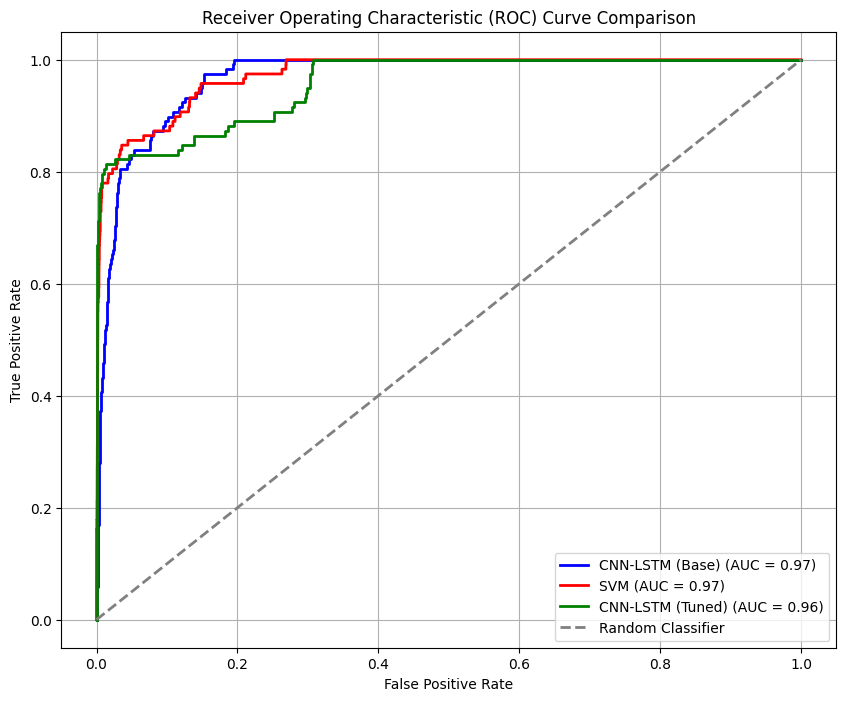

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_prob)
roc_auc_base = auc(fpr_base, tpr_base)


fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)


fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)


plt.figure(figsize=(10, 8))
plt.plot(fpr_base, tpr_base, color='blue', lw=2, label=f'CNN-LSTM (Base) (AUC = {roc_auc_base:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_tuned, tpr_tuned, color='green', lw=2, label=f'CNN-LSTM (Tuned) (AUC = {roc_auc_tuned:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

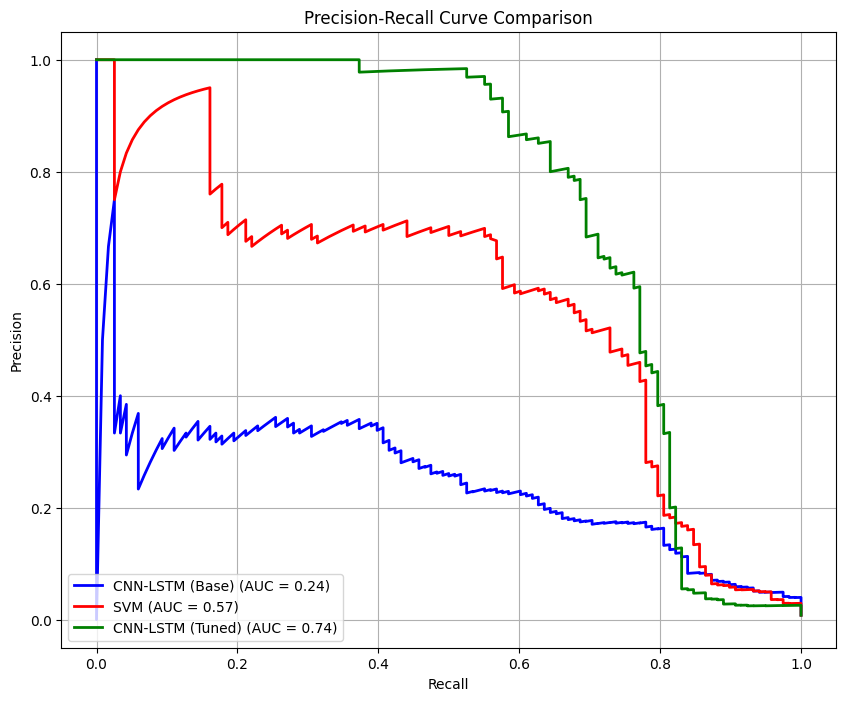

In [ ]:
from sklearn.metrics import precision_recall_curve, auc


precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_prob)
auc_precision_recall_base = auc(recall_base, precision_base)


precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_prob_svm)
auc_precision_recall_svm = auc(recall_svm, precision_svm)


precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_pred_prob_tuned)
auc_precision_recall_tuned = auc(recall_tuned, precision_tuned)


plt.figure(figsize=(10, 8))
plt.plot(recall_base, precision_base, color='blue', lw=2, label=f'CNN-LSTM (Base) (AUC = {auc_precision_recall_base:.2f})')
plt.plot(recall_svm, precision_svm, color='red', lw=2, label=f'SVM (AUC = {auc_precision_recall_svm:.2f})')
plt.plot(recall_tuned, precision_tuned, color='green', lw=2, label=f'CNN-LSTM (Tuned) (AUC = {auc_precision_recall_tuned:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

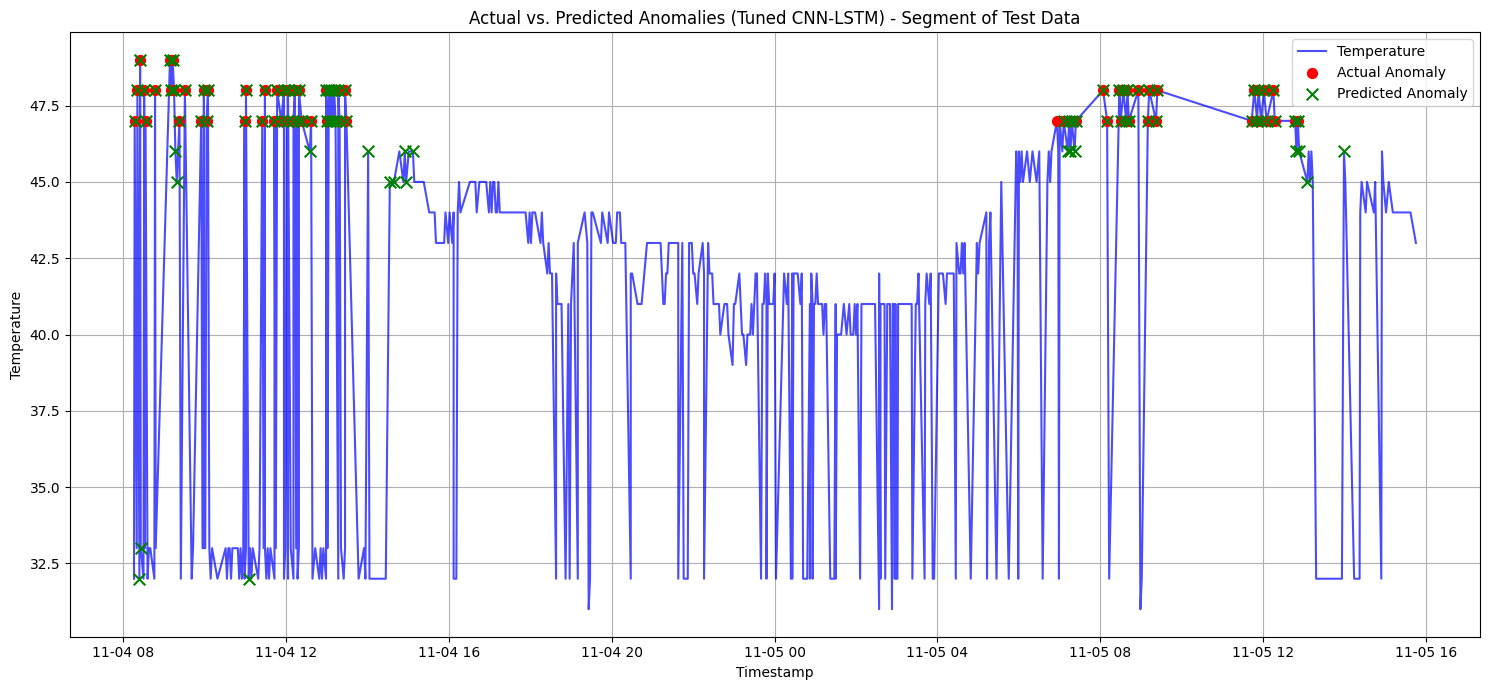

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


segment_start_index = 0
segment_end_index = 500

X_test_segment = X_test[segment_start_index:segment_end_index]
y_test_segment = y_test[segment_start_index:segment_end_index]
y_pred_tuned_segment = y_pred_tuned[segment_start_index:segment_end_index]


test_start_idx_in_full_y = len(y_train) + len(y_val)
test_start_idx_in_df = test_start_idx_in_full_y + WINDOW_SIZE - 1


df_indices_segment = range(
    test_start_idx_in_df + segment_start_index,
    test_start_idx_in_df + segment_end_index
)

timestamps_segment = df['timestamp'].iloc[df_indices_segment].values
temperature_segment = df['temperature'].iloc[df_indices_segment].values


plot_df = pd.DataFrame({
    'timestamp': timestamps_segment,
    'temperature': temperature_segment,
    'actual_outlier': y_test_segment,
    'predicted_outlier': y_pred_tuned_segment.flatten()
})


plt.figure(figsize=(15, 7))
plt.plot(plot_df['timestamp'], plot_df['temperature'], label='Temperature', color='blue', alpha=0.7)


actual_anomalies = plot_df[plot_df['actual_outlier'] == 1]
plt.scatter(
    actual_anomalies['timestamp'],
    actual_anomalies['temperature'],
    color='red',
    marker='o',
    s=50,
    label='Actual Anomaly',
    zorder=5
)


predicted_anomalies = plot_df[plot_df['predicted_outlier'] == 1]
plt.scatter(
    predicted_anomalies['timestamp'],
    predicted_anomalies['temperature'],
    color='green',
    marker='x',
    s=70,
    label='Predicted Anomaly',
    zorder=6
)

plt.title('Actual vs. Predicted Anomalies (Tuned CNN-LSTM) - Segment of Test Data')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Cara Menjalankan
- Pastikan dependency terinstal: tensorflow, keras-tuner, scikit-learn, seaborn, matplotlib.
- Jalankan sel secara berurutan dari atas ke bawah.
- Di lingkungan Google Colab, unggah file `IOT-temp.csv` atau hubungkan ke Google Drive.

Catatan: beberapa sel menjalankan tugas yang memakan waktu (training, tuning); jalankan sesuai kebutuhan.

## Ringkasan  
### Temuan Utama Analisis Data

**Distribusi Label Setelah Windowing**  
Dataset setelah proses windowing menunjukkan adanya ketidakseimbangan yang signifikan, di mana jumlah data normal jauh lebih banyak dibandingkan data anomali.

**Kinerja Model CNN-LSTM Dasar**  
Model CNN-LSTM dasar menghasilkan kinerja dengan Akurasi sebesar **97,43%**, Presisi **18,84%**, Recall **66,10%**, F1-score **29,32%**, dan ROC-AUC **96,91%**. Hasil *confusion matrix* menunjukkan jumlah *false positive* yang relatif tinggi.

**Kinerja Model CNN-LSTM yang Dituning**  
Model CNN-LSTM hasil tuning hyperparameter menunjukkan peningkatan kinerja yang signifikan, dengan hasil sebagai berikut:
- **Akurasi:** 99,51%
- **Presisi:** 68,85%
- **Recall:** 71,19%
- **F1-score:** 70,00%
- **ROC-AUC:** 95,74%

**Perbandingan Model**  
Model CNN-LSTM yang dituning secara signifikan mengungguli CNN-LSTM dasar pada seluruh metrik utama, terutama pada Presisi (dari **18,84%** menjadi **68,85%**) dan F1-score (dari **29,32%** menjadi **70,00%**). Hal ini menunjukkan kemampuan deteksi anomali yang jauh lebih baik dengan jumlah *false alarm* yang lebih rendah.  

Dibandingkan dengan model SVM, CNN-LSTM hasil tuning juga menunjukkan kinerja yang lebih unggul, dengan Akurasi (**99,51%** vs. **98,68%**), Presisi (**68,85%** vs. **35,52%**), dan F1-score (**70,00%** vs. **48,81%**) yang lebih tinggi. Dengan demikian, model CNN-LSTM hasil tuning menjadi model dengan kinerja terbaik di antara seluruh model yang dievaluasi.

---

### Insight atau Langkah Selanjutnya

Proses tuning hyperparameter terbukti sangat efektif dalam meningkatkan kinerja model CNN-LSTM, khususnya pada presisi dan F1-score secara keseluruhan. Hal ini menjadikan model tersebut sebagai solusi yang andal untuk deteksi anomali meskipun dataset bersifat tidak seimbang.  

Penelitian lanjutan dapat difokuskan pada analisis *false negative* pada model hasil tuning untuk mengidentifikasi jenis anomali yang masih sulit terdeteksi, serta mengeksplorasi metode *ensemble* guna meningkatkan kinerja dan kemampuan generalisasi model di masa mendatang.
